# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9950197838682902


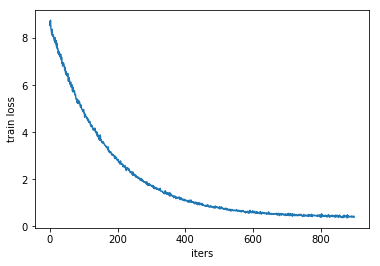

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.e**(-z))

class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+32]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                
                # forward pass
                # <TODO> [1 point] calculate batch loss
                
                z = batch_X @ self.w + self.b
                batch_y_hat = sigmoid(z)
                
                loss = -np.mean(batch_y * np.log(batch_y_hat) + (1 - batch_y) * np.log(1 - batch_y_hat)) + 0.5*self.llambda * self.w.T @ self.w
#                 print(loss)
                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_z = sigmoid(z) - batch_y
                grad_w = batch_X.T @ (batch_y_hat - batch_y) * (1.0/self.batch_size) + self.llambda * self.w
                grad_b = np.mean(grad_z)

                # SGD optimization step
                # <TODO> [1 point]
                self.w = self.w - self.lr * grad_w
                self.b = self.b - self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        p = sigmoid(X @ self.w + self.b)
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [5]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = F.sigmoid(torch.matmul(x, self.W) + self.b)
        return result

In [6]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [7]:
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if len(history['valid']) > early_stopping_patience:
            if non_decreasing(history['valid'][-early_stopping_patience:]):
                return history
    return history

### predict hard labels [1 point]

In [8]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = torch.argmax(model(batch_x), dim=1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [9]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

HBox(children=(IntProgress(value=0, description='epoch:0', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



train loss: 3.010 valid loss:3.002


HBox(children=(IntProgress(value=0, description='epoch:1', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.985 valid loss:2.981


HBox(children=(IntProgress(value=0, description='epoch:2', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.964 valid loss:2.964


HBox(children=(IntProgress(value=0, description='epoch:3', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.947 valid loss:2.948


HBox(children=(IntProgress(value=0, description='epoch:4', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.929 valid loss:2.932


HBox(children=(IntProgress(value=0, description='epoch:5', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.913 valid loss:2.916


HBox(children=(IntProgress(value=0, description='epoch:6', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.896 valid loss:2.901


HBox(children=(IntProgress(value=0, description='epoch:7', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.879 valid loss:2.886


HBox(children=(IntProgress(value=0, description='epoch:8', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.863 valid loss:2.872


HBox(children=(IntProgress(value=0, description='epoch:9', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.848 valid loss:2.858


HBox(children=(IntProgress(value=0, description='epoch:10', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.834 valid loss:2.845


HBox(children=(IntProgress(value=0, description='epoch:11', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.821 valid loss:2.833


HBox(children=(IntProgress(value=0, description='epoch:12', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.807 valid loss:2.822


HBox(children=(IntProgress(value=0, description='epoch:13', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.796 valid loss:2.811


HBox(children=(IntProgress(value=0, description='epoch:14', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.784 valid loss:2.801


HBox(children=(IntProgress(value=0, description='epoch:15', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.773 valid loss:2.791


HBox(children=(IntProgress(value=0, description='epoch:16', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.764 valid loss:2.782


HBox(children=(IntProgress(value=0, description='epoch:17', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.754 valid loss:2.773


HBox(children=(IntProgress(value=0, description='epoch:18', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.745 valid loss:2.765


HBox(children=(IntProgress(value=0, description='epoch:19', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.736 valid loss:2.758


HBox(children=(IntProgress(value=0, description='epoch:20', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.729 valid loss:2.751


HBox(children=(IntProgress(value=0, description='epoch:21', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.721 valid loss:2.744


HBox(children=(IntProgress(value=0, description='epoch:22', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.715 valid loss:2.738


HBox(children=(IntProgress(value=0, description='epoch:23', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.707 valid loss:2.732


HBox(children=(IntProgress(value=0, description='epoch:24', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.701 valid loss:2.727


HBox(children=(IntProgress(value=0, description='epoch:25', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.696 valid loss:2.722


HBox(children=(IntProgress(value=0, description='epoch:26', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.690 valid loss:2.717


HBox(children=(IntProgress(value=0, description='epoch:27', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.685 valid loss:2.712


HBox(children=(IntProgress(value=0, description='epoch:28', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.680 valid loss:2.708


HBox(children=(IntProgress(value=0, description='epoch:29', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.676 valid loss:2.704


HBox(children=(IntProgress(value=0, description='epoch:30', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.672 valid loss:2.701


HBox(children=(IntProgress(value=0, description='epoch:31', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.668 valid loss:2.697


HBox(children=(IntProgress(value=0, description='epoch:32', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.665 valid loss:2.694


HBox(children=(IntProgress(value=0, description='epoch:33', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.661 valid loss:2.691


HBox(children=(IntProgress(value=0, description='epoch:34', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.658 valid loss:2.688


HBox(children=(IntProgress(value=0, description='epoch:35', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.655 valid loss:2.685


HBox(children=(IntProgress(value=0, description='epoch:36', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.652 valid loss:2.683


HBox(children=(IntProgress(value=0, description='epoch:37', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.649 valid loss:2.681


HBox(children=(IntProgress(value=0, description='epoch:38', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.647 valid loss:2.678


HBox(children=(IntProgress(value=0, description='epoch:39', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.644 valid loss:2.676


HBox(children=(IntProgress(value=0, description='epoch:40', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.642 valid loss:2.674


HBox(children=(IntProgress(value=0, description='epoch:41', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.640 valid loss:2.672


HBox(children=(IntProgress(value=0, description='epoch:42', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.638 valid loss:2.671


HBox(children=(IntProgress(value=0, description='epoch:43', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.636 valid loss:2.669


HBox(children=(IntProgress(value=0, description='epoch:44', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.634 valid loss:2.667


HBox(children=(IntProgress(value=0, description='epoch:45', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.633 valid loss:2.666


HBox(children=(IntProgress(value=0, description='epoch:46', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.631 valid loss:2.665


HBox(children=(IntProgress(value=0, description='epoch:47', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.630 valid loss:2.663


HBox(children=(IntProgress(value=0, description='epoch:48', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.628 valid loss:2.662


HBox(children=(IntProgress(value=0, description='epoch:49', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.627 valid loss:2.661


HBox(children=(IntProgress(value=0, description='epoch:50', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.626 valid loss:2.660


HBox(children=(IntProgress(value=0, description='epoch:51', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.625 valid loss:2.659


HBox(children=(IntProgress(value=0, description='epoch:52', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.624 valid loss:2.658


HBox(children=(IntProgress(value=0, description='epoch:53', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.622 valid loss:2.657


HBox(children=(IntProgress(value=0, description='epoch:54', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.622 valid loss:2.656


HBox(children=(IntProgress(value=0, description='epoch:55', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.620 valid loss:2.656


HBox(children=(IntProgress(value=0, description='epoch:56', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.620 valid loss:2.655


HBox(children=(IntProgress(value=0, description='epoch:57', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.619 valid loss:2.654


HBox(children=(IntProgress(value=0, description='epoch:58', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.618 valid loss:2.654


HBox(children=(IntProgress(value=0, description='epoch:59', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.618 valid loss:2.653


HBox(children=(IntProgress(value=0, description='epoch:60', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.617 valid loss:2.652


HBox(children=(IntProgress(value=0, description='epoch:61', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.616 valid loss:2.652


HBox(children=(IntProgress(value=0, description='epoch:62', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.616 valid loss:2.651


HBox(children=(IntProgress(value=0, description='epoch:63', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.615 valid loss:2.651


HBox(children=(IntProgress(value=0, description='epoch:64', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.615 valid loss:2.651


HBox(children=(IntProgress(value=0, description='epoch:65', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.614 valid loss:2.650


HBox(children=(IntProgress(value=0, description='epoch:66', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.614 valid loss:2.650


HBox(children=(IntProgress(value=0, description='epoch:67', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.613 valid loss:2.649


HBox(children=(IntProgress(value=0, description='epoch:68', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.613 valid loss:2.649


HBox(children=(IntProgress(value=0, description='epoch:69', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.613 valid loss:2.648


HBox(children=(IntProgress(value=0, description='epoch:70', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.612 valid loss:2.648


HBox(children=(IntProgress(value=0, description='epoch:71', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.611 valid loss:2.648


HBox(children=(IntProgress(value=0, description='epoch:72', max=36, style=ProgressStyle(description_width='initial')), HTML(value='')))


train loss: 2.611 valid loss:2.648


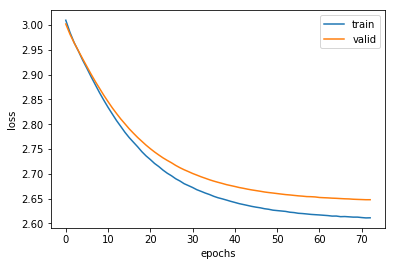

In [10]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [11]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.7505310674455656

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [12]:
nn.CrossEntropyLoss()(torch.rand((y_test.shape[0], len(np.unique(y_test)))), torch.tensor(y_pred)).item()

3.0414931774139404

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [13]:
metrics.accuracy_score(y_test, torch.zeros(y_test.shape[0]))

0.042352628783855546